* Name:Shubham Sahu
* Roll Number:12041430
* References Used to Complete the Assignment
    * a.https://www.brokereviews.com/a/answers/trading-discussions/how-to-calculate-vwap-in-excel
    * b. https://www.kaggle.com/code/tapendrakumar09/zomato-stock-analysis-and-forecasting
    * c. https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/adx
    * d.https://technical-analysis-library-in-python.readthedocs.io/en/latest/

...



In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 27.8 MB/s 
     |████████████████████████████████| 9.9 MB 57.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import itertools
import pandas as pd
import numpy as np
import random 
from scipy import stats
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from pmdarima import auto_arima
import plotly.graph_objects as go
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
from plotly import tools
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import warnings
warnings.filterwarnings("ignore")
import os

In [ ]:
warnings.simplefilter(action='ignore', category= FutureWarning)
# general settings
class CFG:
    data_folder = '../input/tsdata-1/'
    img_dim1 = 20
    img_dim2 = 10
    nepochs = 6
    seed = 42
    EPOCH = 300
    bsize = 16
    BATCH_SIZE = 1024

    
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})   


def seed_everything(seed: int = 42) -> None:
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
seed_everything(CFG.seed)

In [ ]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x,y)) ,4))

In [ ]:
def create_dataset(dataset, look_back, look_ahead):
    xdat, ydat = [], []
    for i in range(len(df) - look_back -look_ahead):
        xdat.append(df[i:i+ look_back ].values)
        ydat.append(df[i+ look_back : i + look_back + look_ahead].values)
    xdat, ydat = np.array(xdat), np.array(ydat).reshape(-1,look_ahead)
    return xdat, ydat

In [ ]:
def prepare_split(xdat, ydat, cutoff = 5000, timesteps = 50):
    xtrain, xvalid = xdat[:cutoff,:], xdat[cutoff:,]
    ytrain, yvalid = ydat[:cutoff,:], ydat[cutoff:,]

    # reshape into [batch size, time steps, dimensionality]
    xtrain = xtrain.reshape(-1, timesteps, 1)
    xvalid = xvalid.reshape(-1, timesteps, 1)

    return xtrain, ytrain, xvalid, yvalid 

###Retrieving data

In [ ]:
# Import yfinance package
import yfinance as yf

start_date = '2000-1-1'
end_date = '2022-10-21'

# Get the data
data = yf.download('HDFC.NS', start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5048 entries, 2002-07-01 to 2022-10-20
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5048 non-null   float64
 1   High       5048 non-null   float64
 2   Low        5048 non-null   float64
 3   Close      5048 non-null   float64
 4   Adj Close  5048 non-null   float64
 5   Volume     5048 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 276.1 KB


In [ ]:
data['Date']=data.index

In [ ]:
data.head

<bound method NDFrame.head of                    Open         High          Low        Close    Adj Close  \
Date                                                                          
2002-07-01    64.519997    65.000000    63.599998    63.996002    45.307243   
2002-07-02    64.000000    65.199997    63.750000    64.010002    45.317162   
2002-07-03    62.790001    62.799999    61.500000    61.706001    45.461563   
2002-07-04    62.000000    63.500000    62.000000    62.660000    46.164417   
2002-07-05    63.400002    65.000000    63.000000    64.466003    47.494972   
...                 ...          ...          ...          ...          ...   
2022-10-14  2305.000000  2359.000000  2305.000000  2343.500000  2343.500000   
2022-10-17  2332.000000  2367.000000  2322.500000  2349.250000  2349.250000   
2022-10-18  2355.500000  2366.699951  2322.050049  2331.649902  2331.649902   
2022-10-19  2376.600098  2415.949951  2368.600098  2381.800049  2381.800049   
2022-10-20  2351.60009

In [ ]:
data = data[(np.abs(stats.zscore(data.drop(['Date'], axis=1))) < 3).all(axis=1)]

In [ ]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Date'], dtype='object')

###Data visualization

In [ ]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (20, 9)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
matplotlib.rcParams['lines.linewidth'] = 2
#plt.style.use('fivethirtyeight')

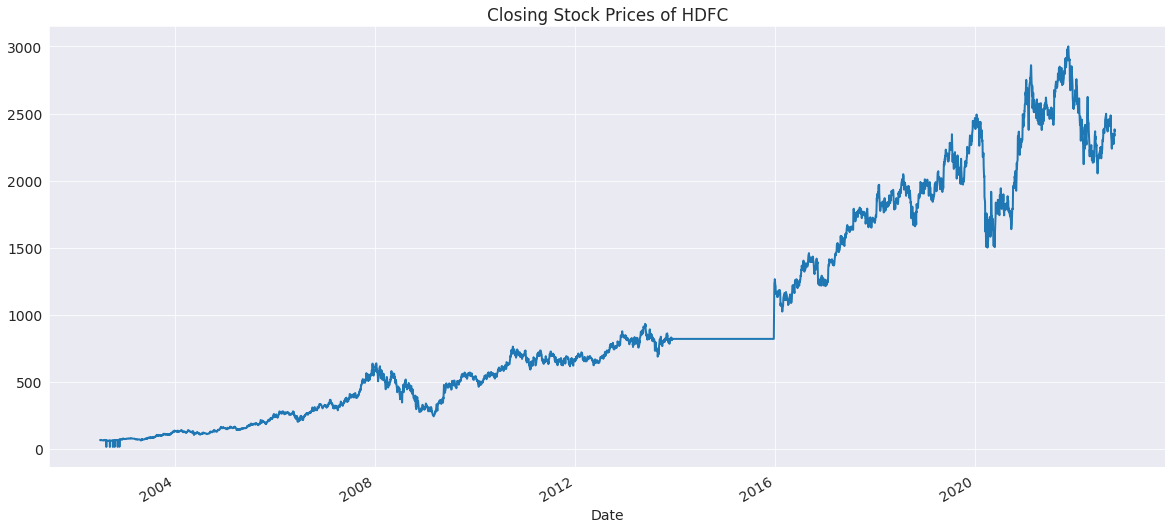

In [ ]:
data['Close'].plot()

plt.title('Closing Stock Prices of HDFC')
plt.show()

some data is missing as it is showing constant curve between 2014 and 2016

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5010 entries, 2002-07-01 to 2022-10-20
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Open       5010 non-null   float64       
 1   High       5010 non-null   float64       
 2   Low        5010 non-null   float64       
 3   Close      5010 non-null   float64       
 4   Adj Close  5010 non-null   float64       
 5   Volume     5010 non-null   int64         
 6   Date       5010 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 313.1 KB


In [ ]:
data.loc[data['Volume'].nlargest(10).index]

,Open,High,Low,Close,Adj Close,Volume,Date
Date,,,,,,,
2009-03-31,292.000000,299.399994,279.470001,282.440002,233.541016,13109305,2009-03-31
2008-11-19,284.399994,298.100006,270.000000,273.230011,225.925613,13109250,2008-11-19
2008-12-18,309.940002,313.940002,295.440002,306.910004,253.774643,13018900,2008-12-18
2020-05-26,1516.000000,1568.150024,1486.000000,1502.150024,1437.609619,12752483,2020-05-26
2008-03-10,505.049988,548.799988,502.200012,510.770020,417.618683,12495995,2008-03-10
2020-05-27,1513.000000,1578.000000,1490.000000,1570.400024,1502.927246,12428419,2020-05-27
2013-09-19,839.000000,843.599976,822.500000,834.549988,731.934387,12423950,2013-09-19
2008-07-23,450.000000,481.000000,440.000000,475.279999,392.994598,12379595,2008-07-23
2012-11-30,822.049988,849.900024,822.000000,843.500000,728.445801,12378473,2012-11-30


In [ ]:
data.loc[data['Close'].nlargest(5).index]

,Open,High,Low,Close,Adj Close,Volume,Date
Date,,,,,,,
2021-11-15,3004.000000,3021.100098,2971.000000,3000.850098,2962.820557,3248126,2021-11-15
2021-11-12,2925.000000,2998.000000,2905.449951,2992.649902,2954.724121,2802442,2021-11-12
2021-11-08,2929.000000,3002.000000,2906.149902,2979.550049,2941.790283,5481172,2021-11-08
2021-11-16,2986.199951,2999.250000,2957.699951,2975.449951,2937.742188,4242014,2021-11-16
2021-11-17,2956.100098,2977.199951,2932.250000,2948.399902,2911.034912,2398355,2021-11-17


In [ ]:
data['TotalTraded'] = data['Open'] * data['Volume']

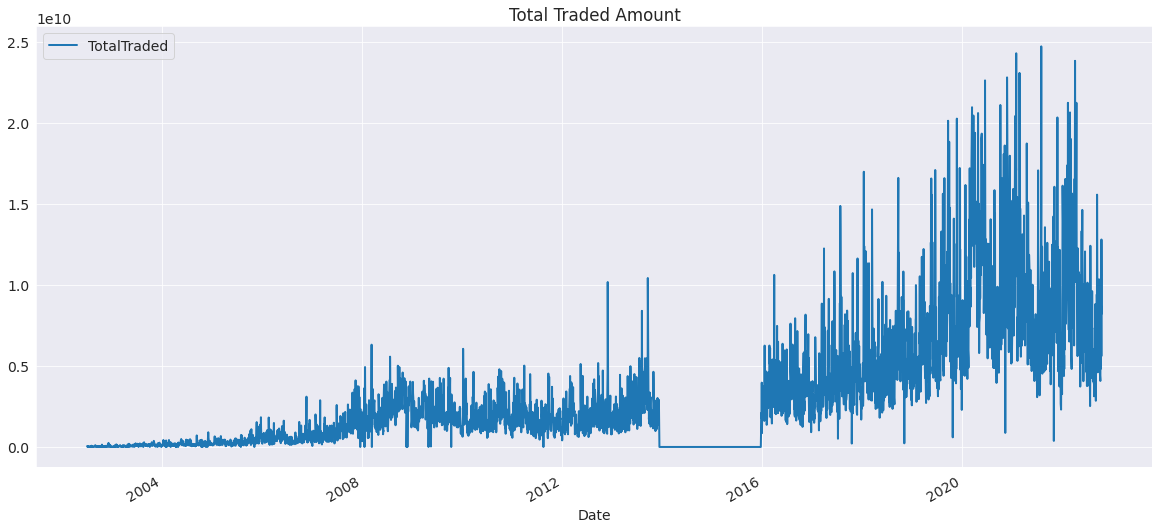

In [ ]:
data['TotalTraded'].plot()

plt.title('Total Traded Amount')
plt.legend()

In [ ]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume,TotalTraded
count,5010.000000,5010.000000,5010.000000,5010.000000,5010.000000,5.010000e+03,5.010000e+03
mean,967.491767,978.112984,955.840279,967.010692,891.725288,2.665687e+06,2.954753e+09
std,783.040592,790.603779,774.330790,782.507465,776.062949,2.125333e+06,3.638923e+09
min,11.875200,11.875200,11.875200,11.875200,8.748991,0.000000e+00,0.000000e+00
25%,320.064995,327.577507,314.099998,320.790001,259.329735,1.295532e+06,2.552880e+08
50%,727.125000,734.750000,714.800018,724.525024,613.791016,2.322070e+06,1.730140e+09
75%,1665.074982,1692.449982,1645.024963,1661.112518,1563.435883,3.507070e+06,4.157319e+09
max,3004.000000,3021.100098,2971.000000,3000.850098,2962.820557,1.310930e+07,2.471637e+10


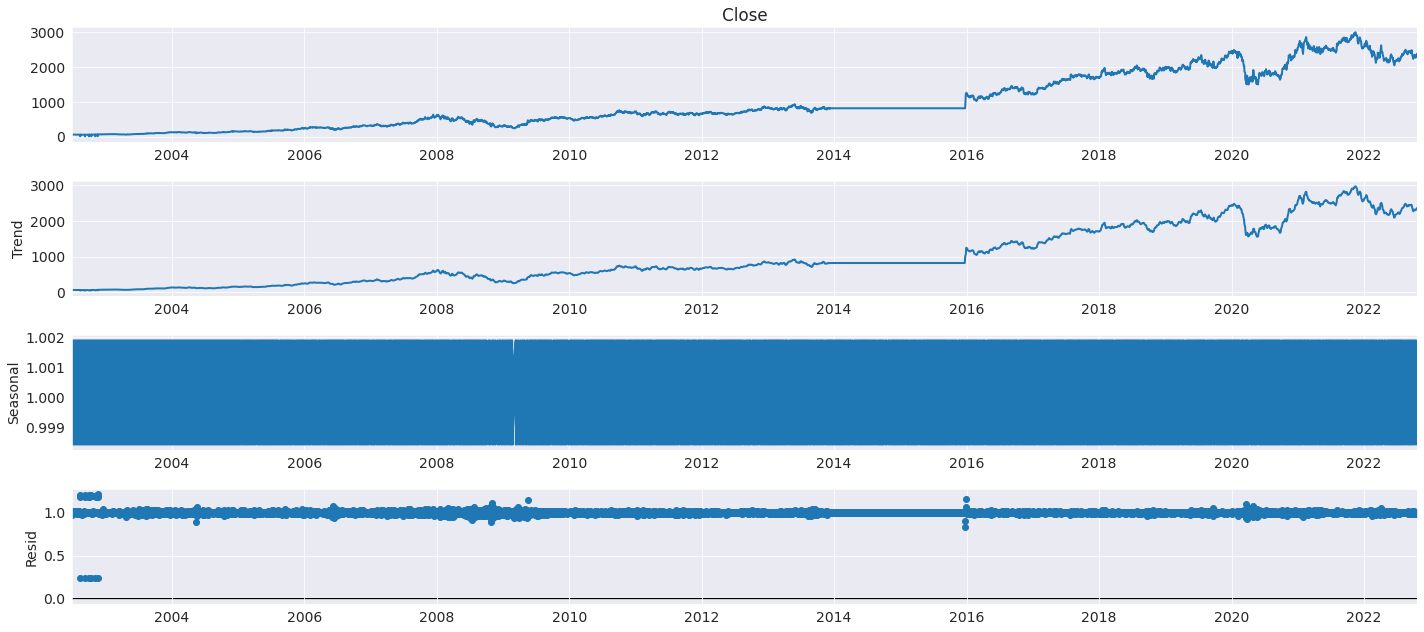

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data['Close'], model='mul', period=5)
result.plot();

no seasonality was there in data as data is following trend component and there are no variation in seasonal curve as well.

###adding features

In [ ]:
!pip install --upgrade ta
from ta import add_all_ta_features
from ta.utils import dropna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


using ADX indicator to see trends

.ADX ≤ 25: No trend

.25 < ADX ≤ 50: Trending

.ADX > 50: Strong Trending

In [ ]:
ti_data = add_all_ta_features(data, open='Open', high='High', low='Low', close='Close', volume='Volume')

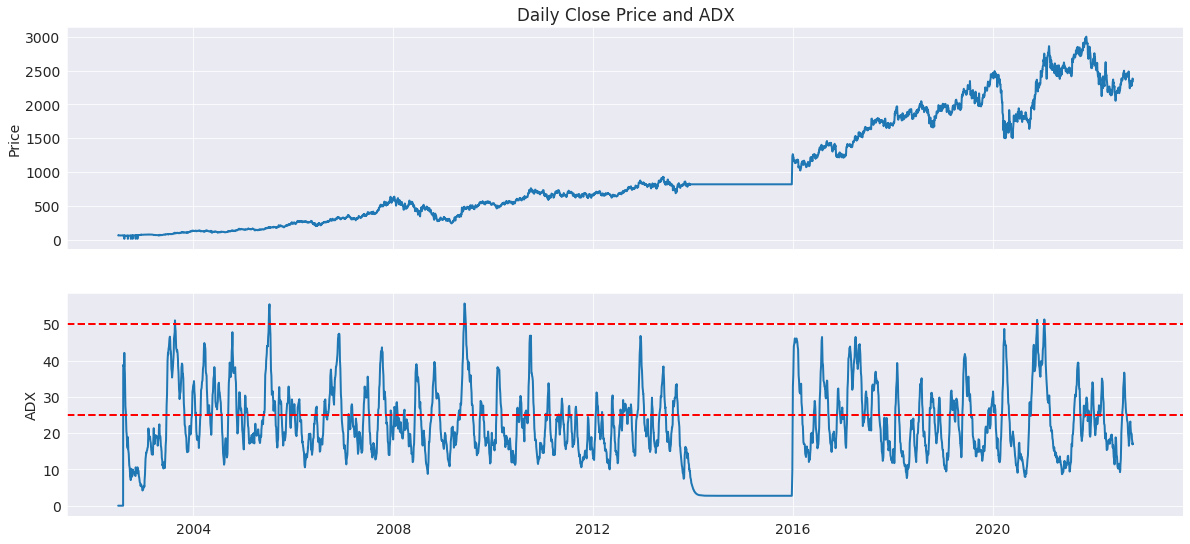

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.set_ylabel('Price')
ax1.plot(data['Close'])
ax2.set_ylabel('ADX')
ax2.plot(ti_data['trend_adx'])
ax1.set_title('Daily Close Price and ADX')
ax2.axhline(y = 50, color = 'r', linestyle = '--')
ax2.axhline(y = 25, color = 'r', linestyle = '--')
plt.show()

In [ ]:
data.index

DatetimeIndex(['2002-07-01', '2002-07-02', '2002-07-03', '2002-07-04',
               '2002-07-05', '2002-07-08', '2002-07-09', '2002-07-10',
               '2002-07-11', '2002-07-12',
               ...
               '2022-10-07', '2022-10-10', '2022-10-11', '2022-10-12',
               '2022-10-13', '2022-10-14', '2022-10-17', '2022-10-18',
               '2022-10-19', '2022-10-20'],
              dtype='datetime64[ns]', name='Date', length=5010, freq=None)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5010 entries, 2002-07-01 to 2022-10-20
Data columns (total 93 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Open                       5010 non-null   float64       
 1   High                       5010 non-null   float64       
 2   Low                        5010 non-null   float64       
 3   Close                      5010 non-null   float64       
 4   Adj Close                  5010 non-null   float64       
 5   Volume                     5010 non-null   int64         
 6   Date                       5010 non-null   datetime64[ns]
 7   volume_adi                 5010 non-null   float64       
 8   volume_obv                 5010 non-null   int64         
 9   volume_cmf                 4991 non-null   float64       
 10  volume_fi                  4997 non-null   float64       
 11  volume_em                  4473 non-null   float64 

###fbprophet

In [ ]:
data.head()

,Open,High,Low,y,Adj Close,Volume,Date,TotalTraded,volume_adi,volume_obv,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2002-07-01,64.519997,65.000000,63.599998,63.996002,45.307243,813320,2002-07-01,5.247540e+07,-353209.432755,813320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-93.382079,NaN,0.000000
2002-07-02,64.000000,65.199997,63.750000,64.010002,45.317162,676020,2002-07-02,4.326528e+07,-786792.171977,1489340,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.021876,0.021874,0.021876
2002-07-03,62.790001,62.799999,61.500000,61.706001,45.461563,139710,2002-07-03,8.772391e+06,-882224.547419,1349630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.599439,-3.665816,-3.578350
2002-07-04,62.000000,63.500000,62.000000,62.660000,46.164417,129020,2002-07-04,7.999240e+06,-897706.973669,1478650,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.546039,1.534209,-2.087634
2002-07-05,63.400002,65.000000,63.000000,64.466003,47.494972,627880,2002-07-05,3.980759e+07,-605112.747594,2106530,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.882227,2.841472,0.734423


In [ ]:
from prophet import Prophet as ph
from prophet.plot import plot_plotly, plot_components_plotly


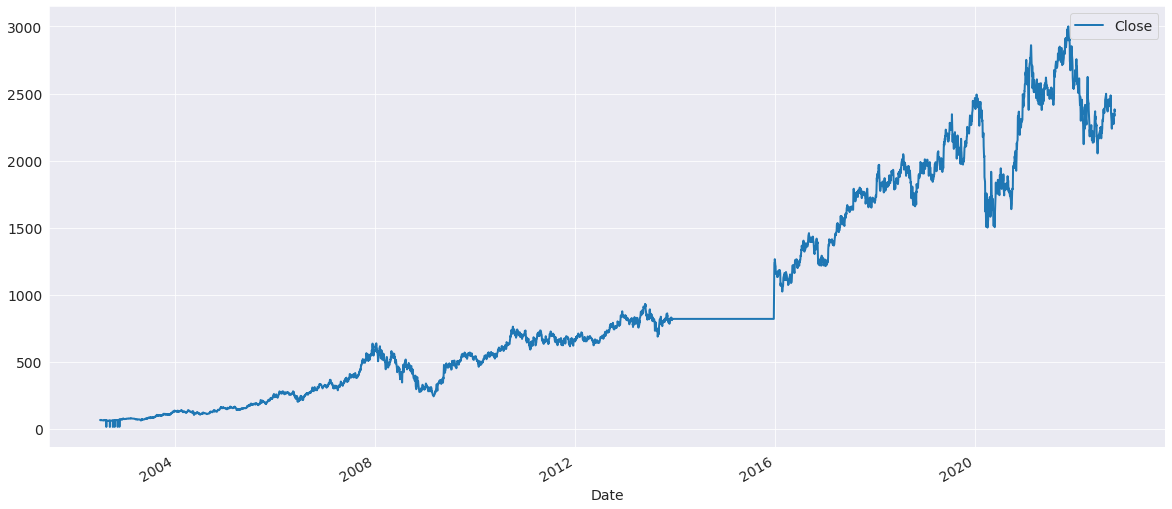

In [ ]:
from matplotlib import pyplot
data.plot(y = 'Close')
pyplot.show()

In [ ]:
data = data.rename(columns={'Close': 'y'})
data = data.rename(columns={'Date': 'ds'})
model = ph()
model.fit(data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
data.tail(10)

,Open,High,Low,y,Adj Close,Volume,ds,TotalTraded,volume_adi,volume_obv,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-07,2302.000000,2333.500000,2301.000000,2326.899902,2326.899902,1942133,2022-10-07,4.470790e+09,9.398363e+07,334895507,...,-1.228797,-0.969645,-0.259152,0.670356,4.683547,-4.013191,2342.551186,0.466293,0.465209,3536.008223
2022-10-10,2295.000000,2316.399902,2264.550049,2298.500000,2298.500000,1774667,2022-10-10,4.072861e+09,9.453298e+07,333120840,...,-1.247059,-1.025128,-0.221931,-2.699265,3.206984,-5.906250,2341.263325,-1.220504,-1.228013,3491.630604
2022-10-11,2283.250000,2305.100098,2267.500000,2271.250000,2271.250000,2703737,2022-10-11,6.173308e+09,9.236855e+07,330417103,...,-1.341157,-1.088334,-0.252823,-2.751757,2.015236,-4.766993,2339.824564,-1.185556,-1.192640,3449.049819
2022-10-12,2275.199951,2309.449951,2271.000000,2301.750000,2301.750000,2115703,2022-10-12,4.813647e+09,9.363687e+07,332532806,...,-1.295332,-1.129733,-0.165599,-4.481250,0.715939,-5.197189,2339.519363,1.342873,1.333936,3496.709046
2022-10-13,2279.000000,2295.850098,2271.000000,2283.250000,2283.250000,3528425,2022-10-13,8.041281e+09,9.358716e+07,329004381,...,-1.308604,-1.165508,-0.143097,-1.686781,0.235395,-1.922176,2338.256294,-0.803736,-0.806984,3467.800990
2022-10-14,2305.000000,2359.000000,2305.000000,2343.500000,2343.500000,3867131,2022-10-14,8.913737e+09,9.523427e+07,332871512,...,-1.096639,-1.151734,0.055095,1.366154,0.461547,0.904607,2338.604526,2.638782,2.604567,3561.947496
2022-10-17,2332.000000,2367.000000,2322.500000,2349.250000,2349.250000,3513903,2022-10-17,8.194422e+09,9.594495e+07,336385415,...,-0.898331,-1.101053,0.202722,2.706856,0.910609,1.796248,2339.005365,0.245360,0.245059,3570.932432
2022-10-18,2355.500000,2366.699951,2322.050049,2331.649902,2331.649902,5434016,2022-10-18,1.279982e+10,9.284759e+07,330951399,...,-0.793167,-1.039476,0.246309,8.380313,2.404550,5.975764,2338.811240,-0.749179,-0.752000,3543.430562
2022-10-19,2376.600098,2415.949951,2368.600098,2381.800049,2381.800049,4465058,2022-10-19,1.061166e+10,9.087203e+07,335416457,...,-0.529905,-0.937562,0.407657,10.092256,3.942091,6.150165,2339.576920,2.150844,2.128040,3621.795061


In [ ]:
future_dates = model.make_future_dataframe(periods=30)
future_dates.tail(10)

,ds
5030,2022-11-10
5031,2022-11-11
5032,2022-11-12
5033,2022-11-13
5034,2022-11-14
5035,2022-11-15
5036,2022-11-16
5037,2022-11-17
5038,2022-11-18
5039,2022-11-19


In [ ]:
future = model.predict(future_dates)

In [ ]:
future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
5030,2022-11-10,2602.010404,2439.719279,2765.671001
5031,2022-11-11,2601.071469,2436.669877,2757.754520
5032,2022-11-12,2630.503127,2476.107422,2789.211822
5033,2022-11-13,2617.513170,2446.946063,2786.371370
5034,2022-11-14,2602.189027,2434.718874,2772.592534
5035,2022-11-15,2604.960553,2442.761432,2779.873938
5036,2022-11-16,2604.424200,2438.742102,2769.093272
5037,2022-11-17,2606.171321,2435.463885,2766.977784
5038,2022-11-18,2605.021332,2451.845434,2778.534054
5039,2022-11-19,2634.279678,2467.584258,2802.713265


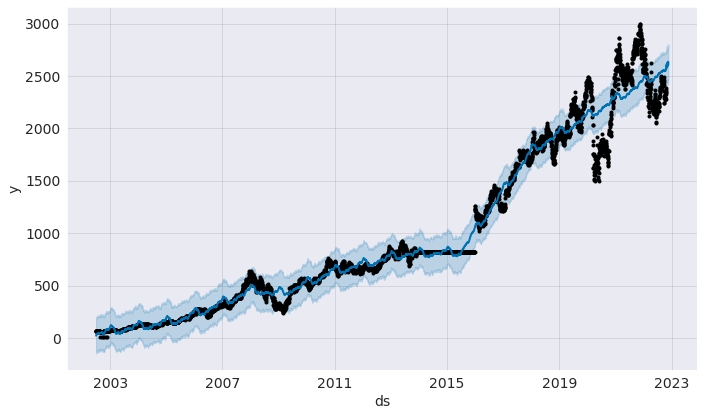

In [ ]:
fig2 = model.plot(future)

here the black plot shows the our input while blue one shows our model predictions

###ARIMA

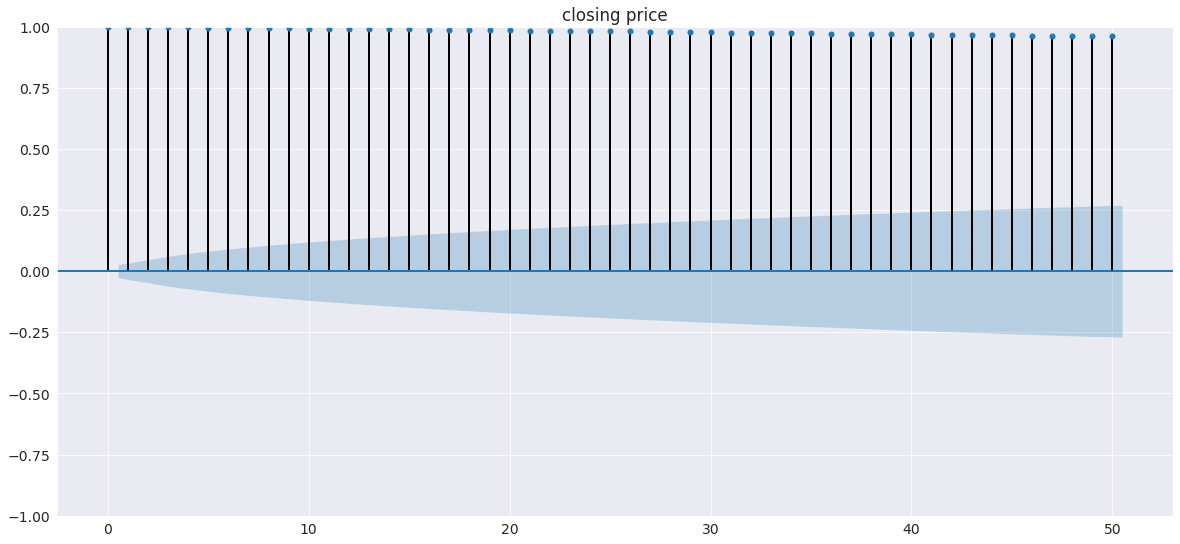

In [ ]:
plot_acf(data.Close, lags=50, title="closing price")
plt.show()

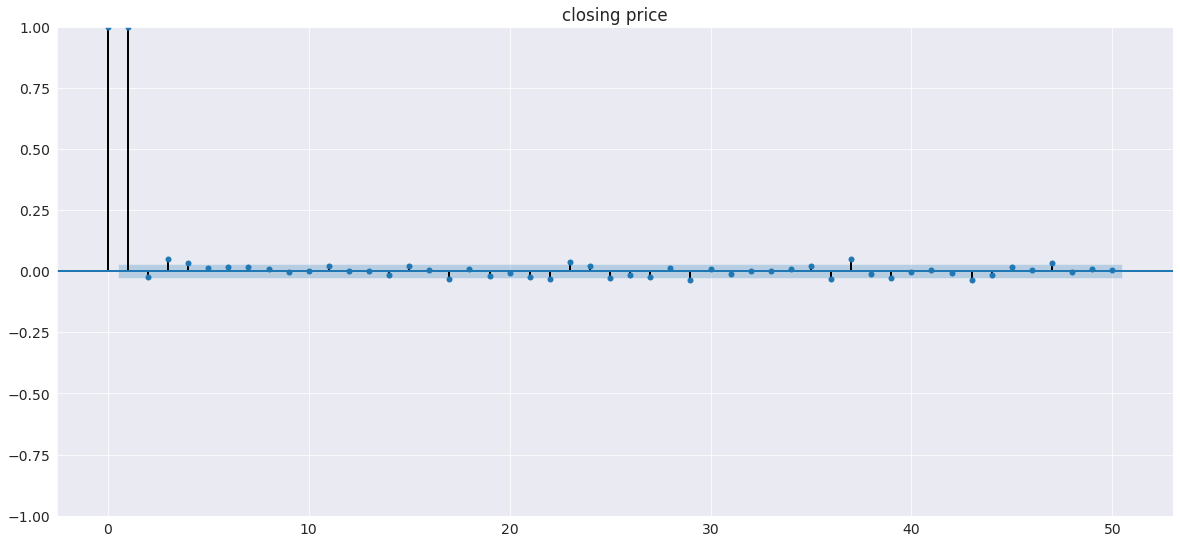

In [ ]:
plot_pacf(data.Close, lags=50, title="closing price")
plt.show()

In [ ]:
train_data, test_data = data[:int(len(data)*0.8)], data[int(len(data)*0.8):]

In [ ]:
# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima   

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=32507.486, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=32520.444, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=32510.316, Time=1.30 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=32508.933, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=32522.534, Time=0.08 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=32499.972, Time=1.47 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=32508.874, Time=0.77 sec
 ARIMA(0,1,0)(2,0,1)[5] intercept   : AIC=32501.242, Time=2.88 sec
 ARIMA(0,1,0)(1,0,2)[5] intercept   : AIC=32501.255, Time=3.74 sec
 ARIMA(0,1,0)(0,0,2)[5] intercept   : AIC=32500.733, Time=1.21 sec
 ARIMA(0,1,0)(2,0,0)[5] intercept   : AIC=32502.067, Time=2.56 sec
 ARIMA(0,1,0)(2,0,2)[5] intercept   : AIC=32500.253, Time=5.82 sec
 ARIMA(1,1,0)(1,0,1)[5] intercept   : AIC=32501.362, Time=3.87 sec
 ARIMA(0,1,1)(1,0,1)[5] intercept   : AIC=32501.324, Time=2.29 sec
 ARIMA(1,1,1)(1,0,1

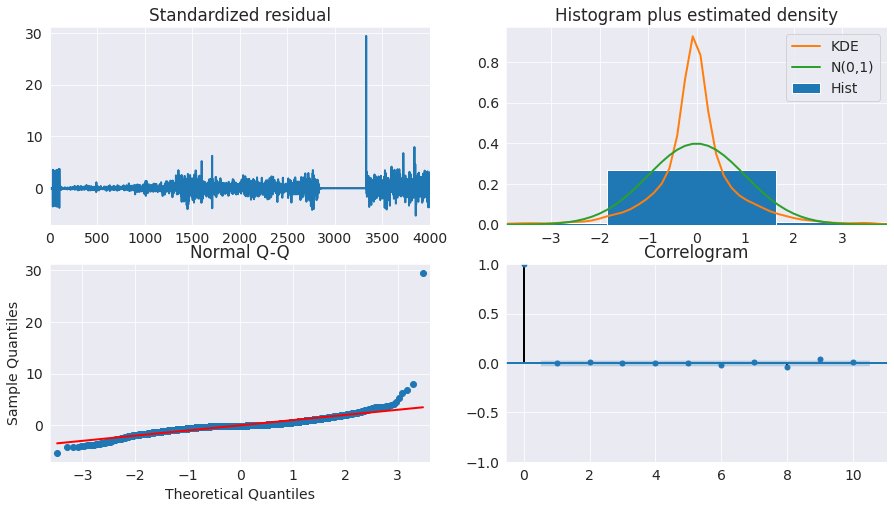

In [ ]:
model_autoARIMA = auto_arima(train_data['Close'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=12, max_q=12, # maximum p and q
                      m=5,              # frequency of series
                      d=None,           # let model determine 'd'
                      start_P=0, 
                      D=0, 
                      trace=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
model = SARIMAX(train_data['Close'],order=(0,1,0))	
results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 4008
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -16260.267
Date:                Sat, 05 Nov 2022   AIC                          32522.534
Time:                        22:06:38   BIC                          32528.830
Sample:                             0   HQIC                         32524.765
                               - 4008                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       195.9883      0.452    433.790      0.000     195.103     196.874
===================================================================================
Ljung-Box (L1) (Q):                   1.03   Jarque-Bera (JB):           5766757.21
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               8.74   Skew:                             6.47
Prob(H) (two-sided):                  0.00   Kurtosis:                       188.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX(0, 1, 0) Predictions')

In [ ]:
predictions.index = list(predictions.index)
predictions.index  = test_data.index

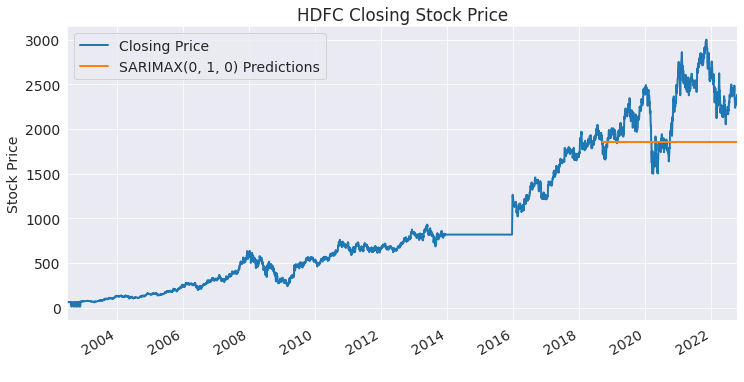

In [ ]:
# Plot predictions against known values
title = 'HDFC Closing Stock Price'
ylabel='Stock Price'

ax = data['Close'].plot(legend=True,figsize=(12,6),title=title, label='Closing Price')

predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=' ', ylabel=ylabel);

In [ ]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test_data['Close'], predictions, squared=False)
print(f'RMSE Error: {error:11.10}')

RMSE Error: 505.9967155


In [ ]:
hdfc_close  = data.filter(['Close']).values


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))
hdfc_scaled=scaler.fit_transform(hdfc_close)

In [ ]:
period = 45

In [ ]:
training_size=int(len(hdfc_scaled)*0.8)
test_size=len(hdfc_scaled)-training_size
train_data,test_data=hdfc_scaled[0:training_size,:],hdfc_scaled[training_size-45:,:]

In [ ]:
x_train = []
y_train= []

In [ ]:
# Preparing target and feature sets

from tqdm import tqdm
for i in tqdm(range(period, len(train_data))):
    x_train.append(train_data[i-45:i, 0])
    y_train.append(train_data[i, 0])

100%|██████████| 3963/3963 [00:00<00:00, 393663.01it/s]


In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
# Reshaping features into the size that is convinient for LSTM model training

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape


(3963, 45, 1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
model = Sequential(
    [
        LSTM(50, input_shape=(x_train.shape[1], 1), return_sequences=True),
        LSTM(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ]
)

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Training the model
model.fit(x_train, y_train,
         batch_size=1,
         epochs=15)

Epoch 1/15
3963/3963 [==============================] - 59s 15ms/step - loss: 8.7542e-05
Epoch 2/15
3963/3963 [==============================] - 57s 14ms/step - loss: 8.8234e-05
Epoch 3/15
3963/3963 [==============================] - 57s 14ms/step - loss: 7.8313e-05
Epoch 4/15
3963/3963 [==============================] - 59s 15ms/step - loss: 7.5650e-05
Epoch 5/15
3963/3963 [==============================] - 57s 14ms/step - loss: 6.1791e-05
Epoch 6/15
3963/3963 [==============================] - 58s 15ms/step - loss: 6.5961e-05
Epoch 7/15
3963/3963 [==============================] - 57s 14ms/step - loss: 6.2903e-05
Epoch 8/15
3963/3963 [==============================] - 58s 15ms/step - loss: 5.5898e-05
Epoch 9/15
3963/3963 [==============================] - 57s 14ms/step - loss: 5.9307e-05
Epoch 10/15
3963/3963 [==============================] - 58s 15ms/step - loss: 5.5548e-05
Epoch 11/15
3963/3963 [==============================] - 58s 15ms/step - loss: 5.1544e-05
Epoch 12/15
3963/39

In [ ]:
x_test, y_test = [], hdfc_close[training_size:, :]

for i in range(period, len(test_data)):
    x_test.append(test_data[i-45:i, 0])

In [ ]:
 x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
pred = model.predict(x_test)

32/32 [==============================] - 0s 10ms/step


In [ ]:
# Converting predictions from scaled values to original values
pred = scaler.inverse_transform(pred)

In [ ]:
# Computing RMSE loss
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, pred, squared = False)

117.79740231112334

we get better rmse values with lstm model then arima

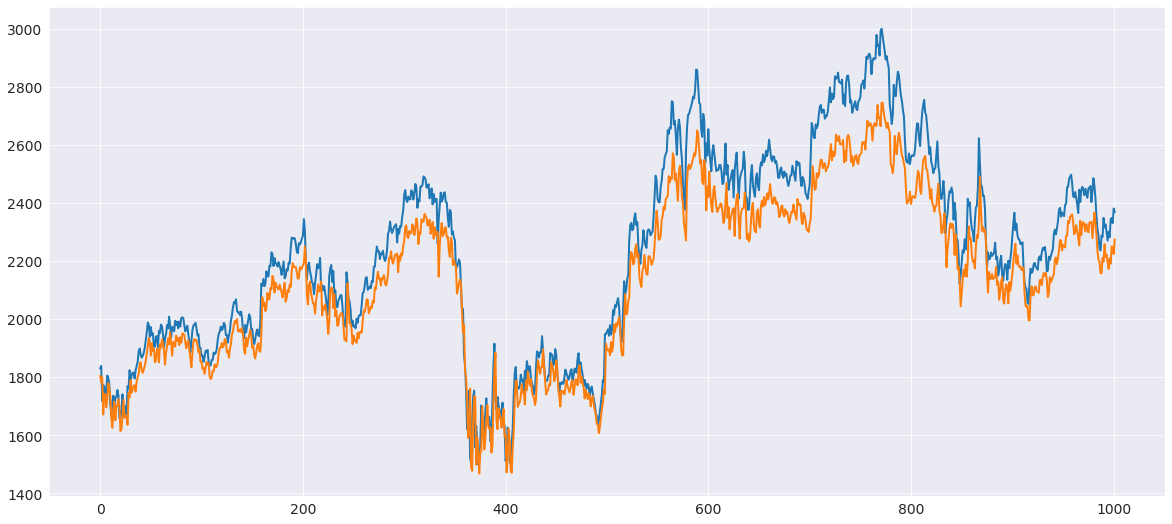

In [ ]:
plt.plot(y_test)
plt.plot(pred)

here it is visible from the curve

###effect of ukraine - russia war on nifty 50 stocks

In [ ]:
# Import yfinance package
import yfinance as yf

start_date = '2022-1-1'
end_date = '2022-11-1'

# Get the data
df = yf.download('HDFC.NS', start_date, end_date)

[*********************100%***********************]  1 of 1 completed


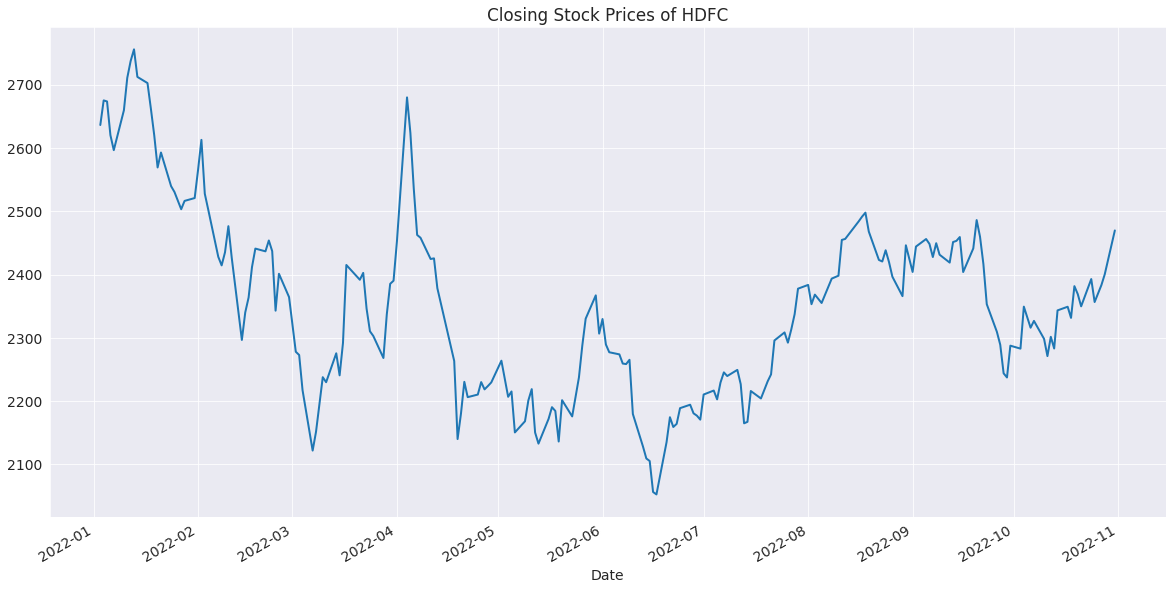

In [ ]:
df['Close'].plot()

plt.title('Closing Stock Prices of HDFC')
plt.show()

on nifty 50 stocks

[*********************100%***********************]  1 of 1 completed


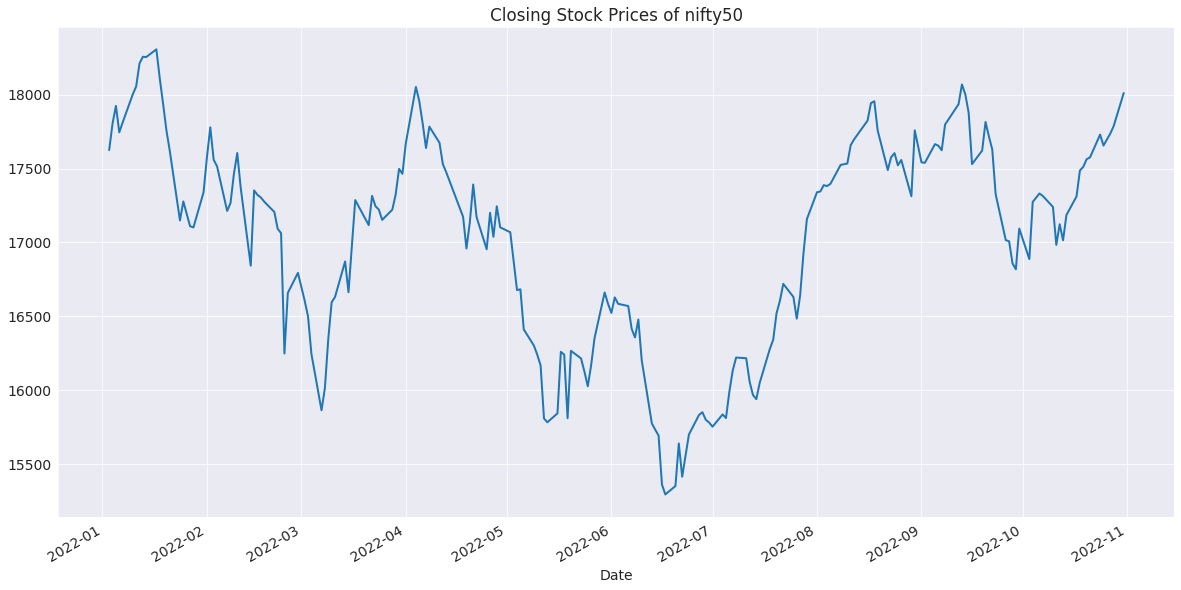

In [ ]:
# Import yfinance package
import yfinance as yf

start_date = '2022-1-1'
end_date = '2022-11-1'

# Get the data
df = yf.download('^NSEI', start_date, end_date)

#plotting closing price curve
df['Close'].plot()

plt.title('Closing Stock Prices of nifty50')
plt.show()

invasion began at 24th feb hence can see significant drop at end of february and continued drop is continued for some time in march and price starts to recover after that.

####AUTOMOBILE COMPANIES IN NIFTY 50

[*********************100%***********************]  1 of 1 completed


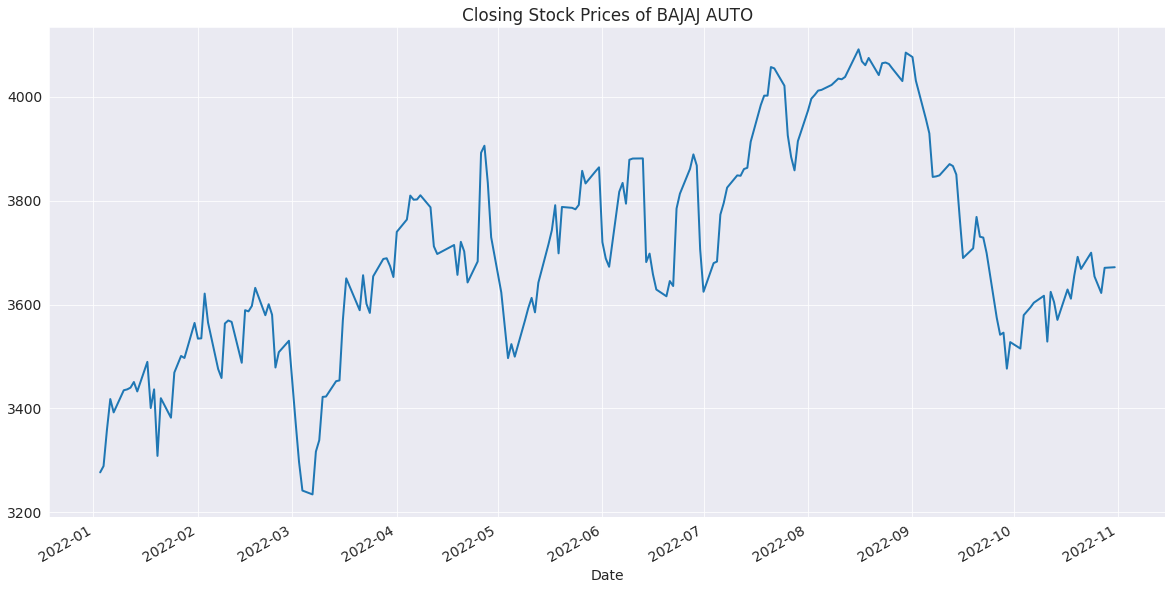

In [ ]:
# Import yfinance package
import yfinance as yf

start_date = '2022-1-1'
end_date = '2022-11-1'

# Get the data
df = yf.download('BAJAJ-AUTO.NS', start_date, end_date)

#plotting closing price curve
df['Close'].plot()

plt.title('Closing Stock Prices of BAJAJ AUTO')
plt.show()

[*********************100%***********************]  1 of 1 completed


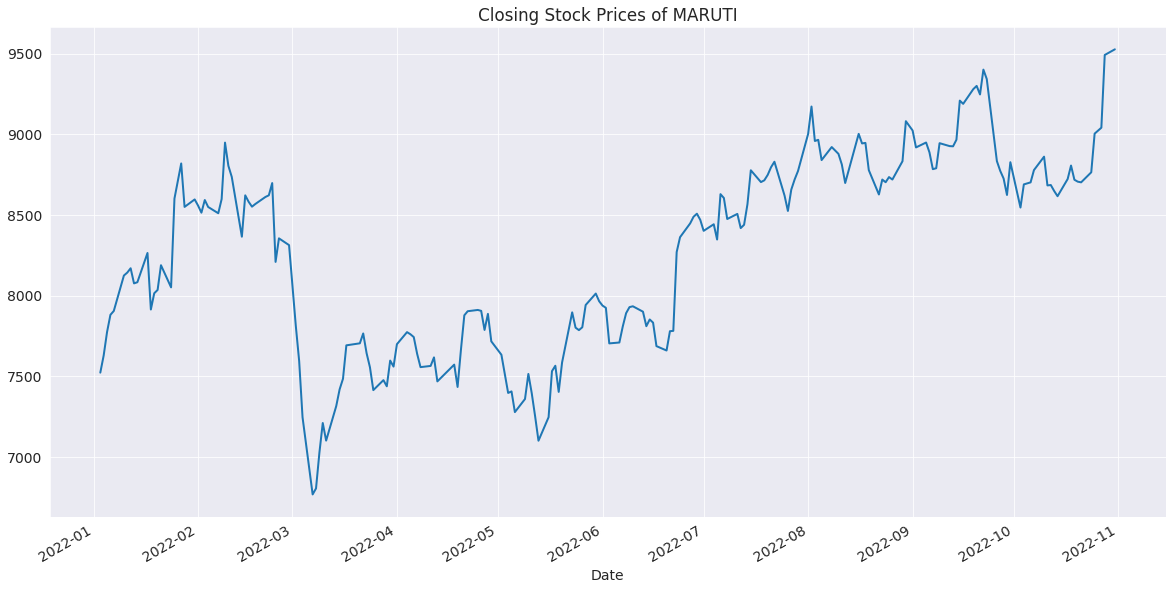

In [ ]:
# Import yfinance package
import yfinance as yf

start_date = '2022-1-1'
end_date = '2022-11-1'

# Get the data
df = yf.download('MARUTI.NS', start_date, end_date)

#plotting closing price curve
df['Close'].plot()

plt.title('Closing Stock Prices of MARUTI')
plt.show()

[*********************100%***********************]  1 of 1 completed


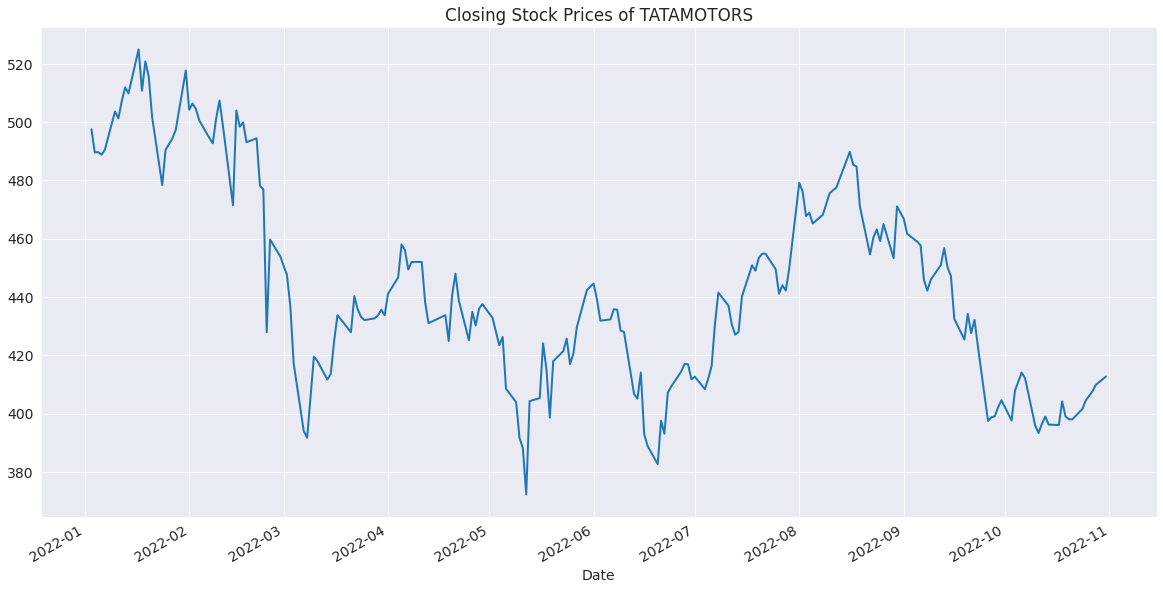

In [ ]:
# Import yfinance package
import yfinance as yf

start_date = '2022-1-1'
end_date = '2022-11-1'

# Get the data
df = yf.download('TATAMOTORS.NS', start_date, end_date)

#plotting closing price curve
df['Close'].plot()

plt.title('Closing Stock Prices of TATAMOTORS')
plt.show()

[*********************100%***********************]  1 of 1 completed


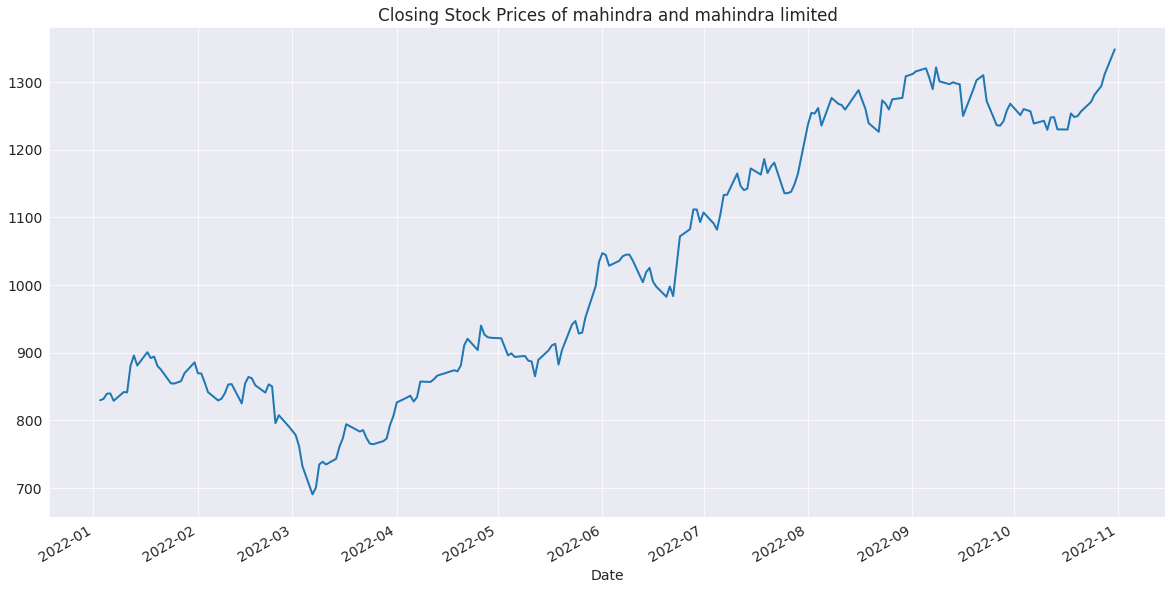

In [ ]:
# Import yfinance package
import yfinance as yf

start_date = '2022-1-1'
end_date = '2022-11-1'

# Get the data
df = yf.download('M&M.NS', start_date, end_date)

#plotting closing price curve
df['Close'].plot()

plt.title('Closing Stock Prices of mahindra and mahindra limited')
plt.show()

auto mobile companies have observed significant drop in their share prices as prices of crude oil have increased though since india has not imposed any restrictions stocks have recovered pretty quickly as well. around amrch start there was also disruption in supply of some parts from region. 

[*********************100%***********************]  1 of 1 completed


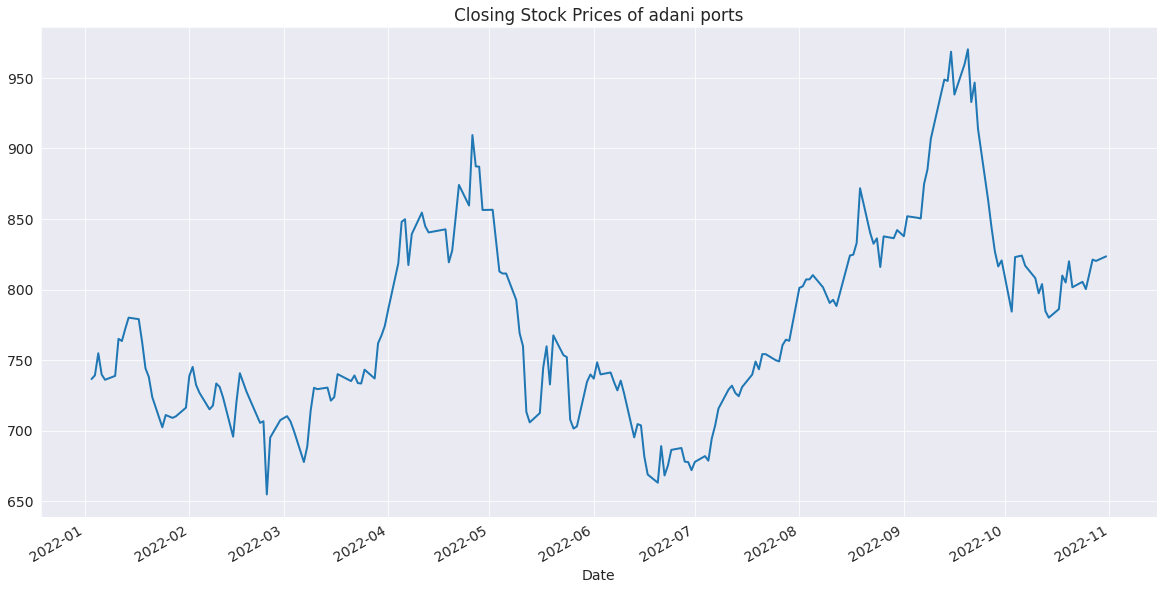

In [ ]:
# Import yfinance package
import yfinance as yf

start_date = '2022-1-1'
end_date = '2022-11-1'

# Get the data
df = yf.download('ADANIPORTS.NS', start_date, end_date)

#plotting closing price curve
df['Close'].plot()

plt.title('Closing Stock Prices of adani ports')
plt.show()

for adani ports there was no significant change intitially but later its price increased dramatically.

[*********************100%***********************]  1 of 1 completed


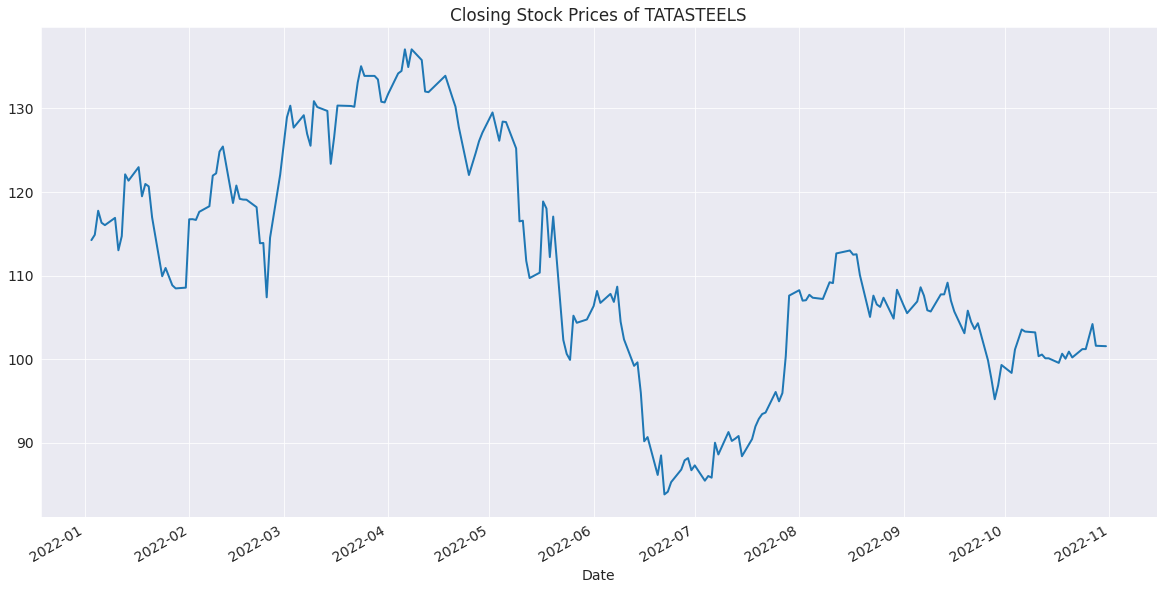

In [ ]:
# Import yfinance package
import yfinance as yf

start_date = '2022-1-1'
end_date = '2022-11-1'

# Get the data
df = yf.download('TATASTEEL.NS', start_date, end_date)

#plotting closing price curve
df['Close'].plot()

plt.title('Closing Stock Prices of TATASTEELS')
plt.show()

Russia is the 5th largest steel producer, while Ukraine ranks 14th globally. Both these countries together account for 20% of the global steel supply and china imposing higher teriff prices on steel exports has caused downfall in steel demand supply chain which made tata steel stock gain value around that time. 

[*********************100%***********************]  1 of 1 completed


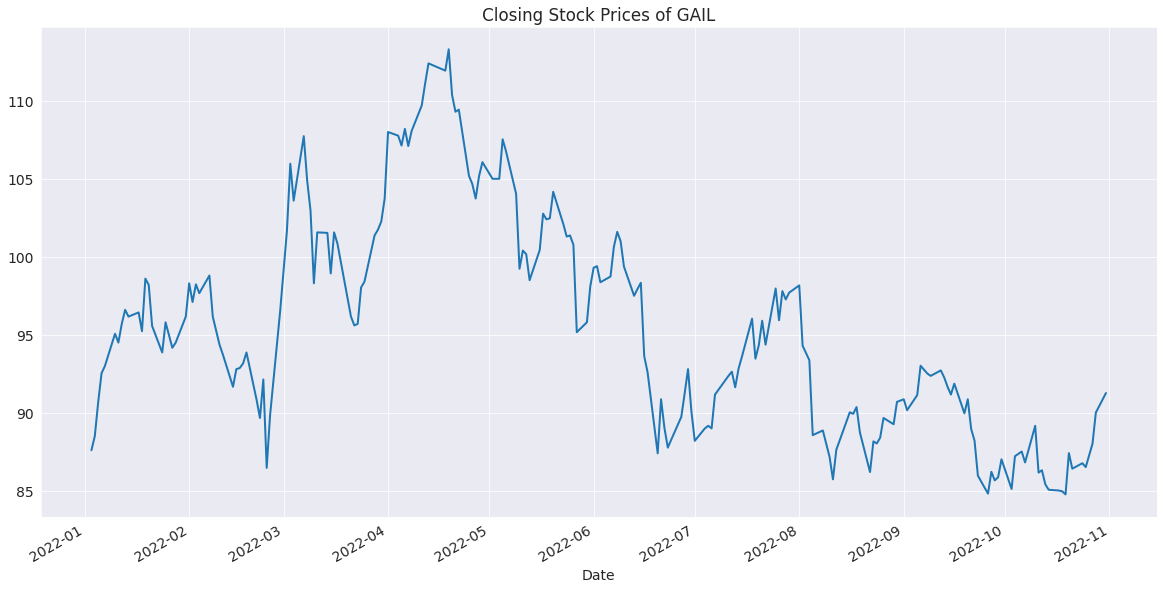

In [ ]:
# Import yfinance package
import yfinance as yf

start_date = '2022-1-1'
end_date = '2022-11-1'

# Get the data
df = yf.download('GAIL.NS', start_date, end_date)

#plotting closing price curve
df['Close'].plot()

plt.title('Closing Stock Prices of GAIL')
plt.show()

its price suddenly increased as gas prices shot up after sanctions on russia.

[*********************100%***********************]  1 of 1 completed


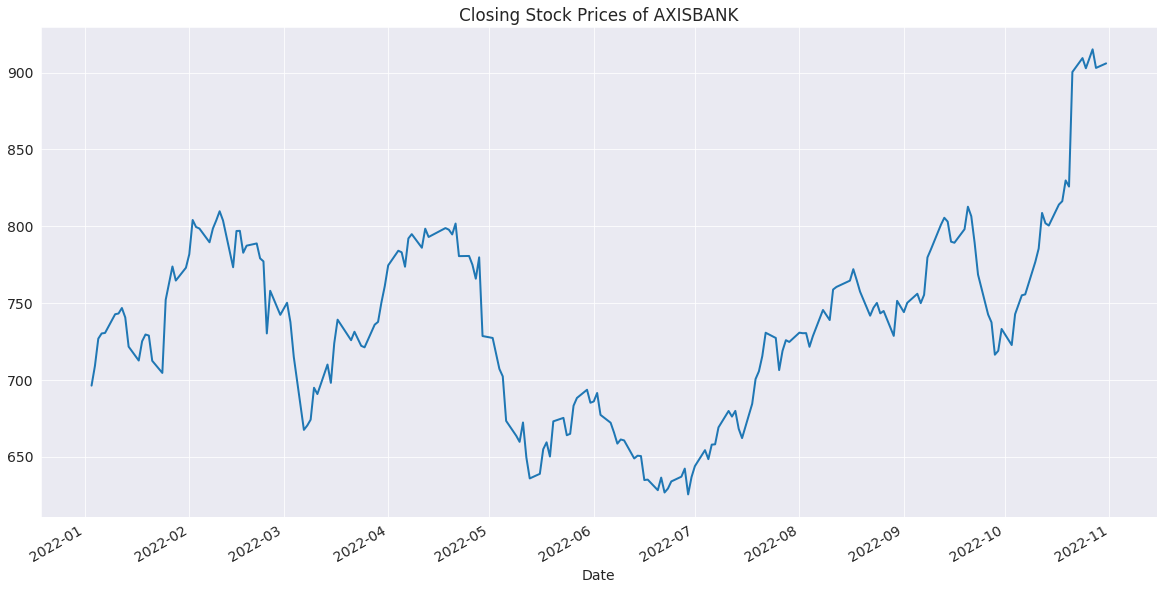

In [ ]:
# Import yfinance package
import yfinance as yf

start_date = '2022-1-1'
end_date = '2022-11-1'

# Get the data
df = yf.download('AXISBANK.NS', start_date, end_date)

#plotting closing price curve
df['Close'].plot()

plt.title('Closing Stock Prices of AXISBANK')
plt.show()

###banking sector

[*********************100%***********************]  1 of 1 completed


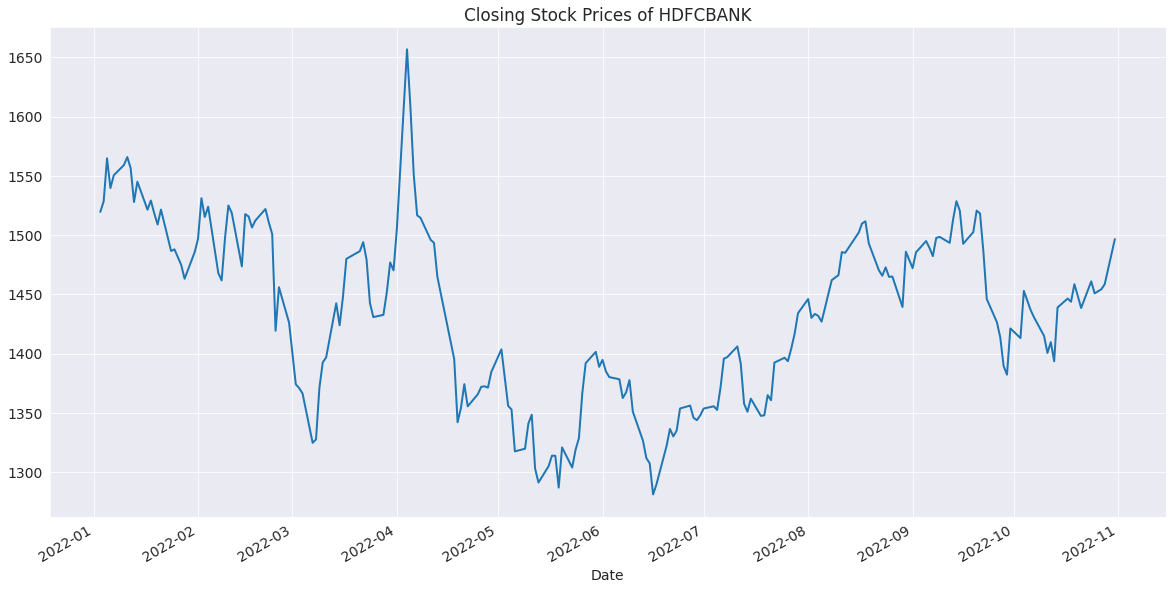

In [ ]:
# Import yfinance package
import yfinance as yf

start_date = '2022-1-1'
end_date = '2022-11-1'

# Get the data
df = yf.download('HDFCBANK.NS', start_date, end_date)

#plotting closing price curve
df['Close'].plot()

plt.title('Closing Stock Prices of HDFCBANK')
plt.show()

[*********************100%***********************]  1 of 1 completed


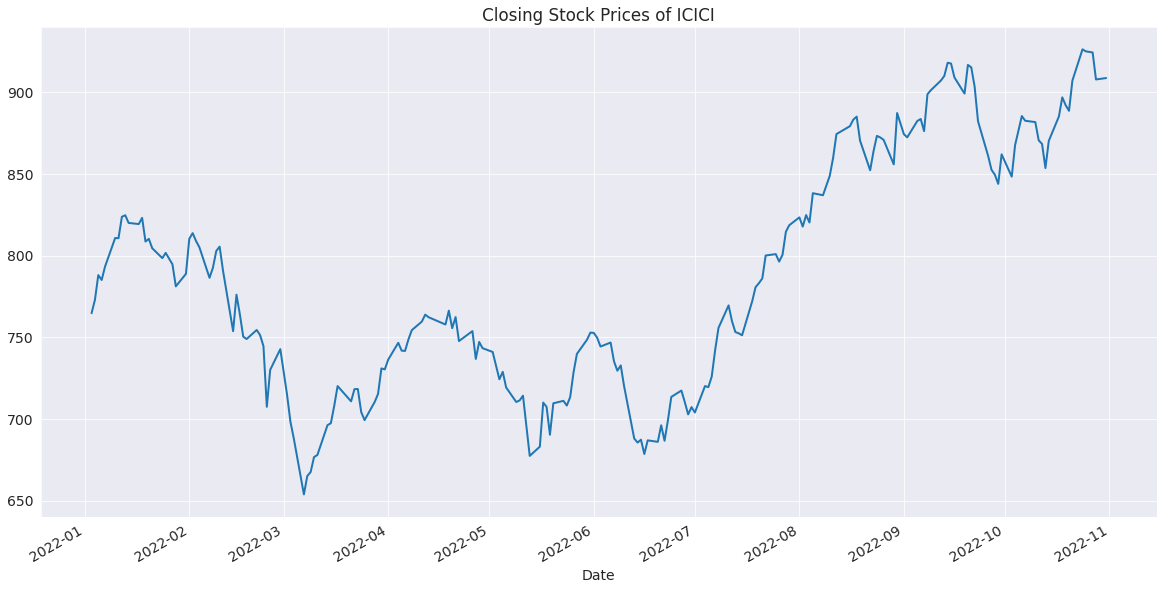

In [ ]:
# Import yfinance package
import yfinance as yf

start_date = '2022-1-1'
end_date = '2022-11-1'

# Get the data
df = yf.download('ICICIBANK.NS', start_date, end_date)

#plotting closing price curve
df['Close'].plot()

plt.title('Closing Stock Prices of ICICI')
plt.show()

[*********************100%***********************]  1 of 1 completed


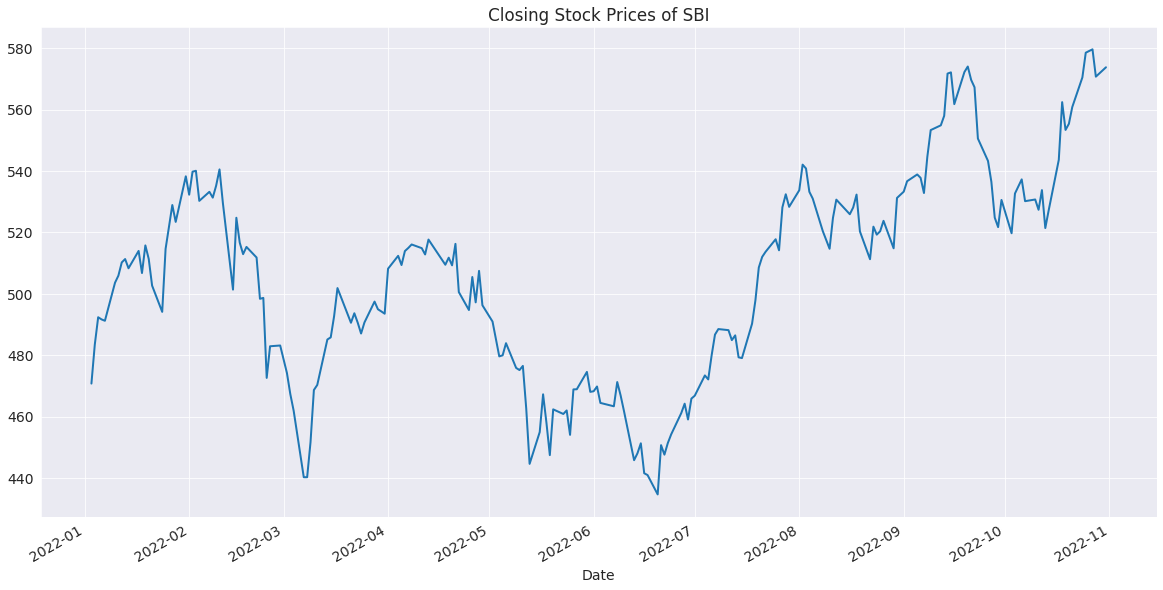

In [ ]:
# Import yfinance package
import yfinance as yf

start_date = '2022-1-1'
end_date = '2022-11-1'

# Get the data
df = yf.download('SBIN.NS', start_date, end_date)

#plotting closing price curve
df['Close'].plot()

plt.title('Closing Stock Prices of SBI')
plt.show()

there has been drop in prices of banks as liquitdity reduced in market because people are paranoid